# Deep Learning

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
import optuna
import plotly
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from optuna.integration import TFKerasPruningCallback
from optuna.visualization import plot_optimization_history, plot_param_importances
from typing import Optional, Tuple
from pandas.testing import assert_frame_equal


# Create a logger instance
logger = logging.getLogger(
    __name__
)

# Set the logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
logger.setLevel(logging.INFO)

# Create a handler
handler = logging.StreamHandler()

# Format the logs to include level, module name, and message
formatter = logging.Formatter("[%(levelname)s] %(name)s - %(message)s")
handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(handler)

logger = logging.getLogger(__name__)

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

plt.rcParams["figure.figsize"] = [10, 6]

## Data Loading

In [18]:
# Load the data
merged_df = (
    pd.read_csv(
        "../data/merged_df.csv", parse_dates=["timestamp"], index_col="timestamp"
    )
    .sort_index()
    .convert_dtypes()
)
arima_predictions_T = (pd.read_csv('../data/arima_predictions_T.csv', parse_dates=['timestamp'], index_col='timestamp')
                       .sort_index()
                       .convert_dtypes())
arima_predictions_V = (pd.read_csv('../data/arima_predictions_VZ.csv', parse_dates=['timestamp'], index_col='timestamp')
                       .sort_index()
                       .convert_dtypes())

In [19]:
merged_df.head

<bound method NDFrame.head of             close_t  close_v weekday_name  market_holiday  t_diff  v_diff
timestamp                                                                
2019-01-02    29.54    56.02    Wednesday           False     0.0     0.0
2019-01-03    29.58    56.22     Thursday           False    0.04     0.2
2019-01-04    30.34    56.36       Friday           False    0.76    0.14
2019-01-05    30.34    56.36     Saturday           False     0.0     0.0
2019-01-06    30.34    56.36       Sunday           False     0.0     0.0
...             ...      ...          ...             ...     ...     ...
2021-05-28    29.43    56.49       Friday           False   -0.28     0.2
2021-05-29    29.43    56.49     Saturday           False     0.0     0.0
2021-05-30    29.43    56.49       Sunday           False     0.0     0.0
2021-05-31    29.43    56.49       Monday            True     0.0     0.0
2021-06-01    29.32    56.38      Tuesday           False   -0.11   -0.11

[882 ro

In [66]:
merged_df = merged_df.drop(columns=['weekday_name', 'market_holiday'])

## Implementing an RNN model class
The RNN is relatively simple to implement. Let's make a class to easily implement it across different datasets.

In [ ]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None: 
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col=None, max_subplots=3):
        if plot_col is None:
            plot_col = self.label_columns[0]  # Default to the first label column if not specified
        
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='red', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [69]:
def split_data(
    df: pd.DataFrame, train_ratio: float = 0.7, val_ratio: float = 0.15
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split a DataFrame into train, validation, and test sets by chronological order.

    Args:
        df (pd.DataFrame): The complete dataset.
        train_ratio (float): Fraction of data to allocate for training.
        val_ratio (float): Fraction of data to allocate for validation.
            The remainder is used for testing.

    Returns:
        (train_df, val_df, test_df): Three DataFrames in chronological order.
    """
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    # Chronological split
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    return train_df, val_df, test_df


def scale_data(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    columns_to_scale: list[str],
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, MinMaxScaler]:
    """
    Scale the specified columns of the train, val, and test DataFrames
    using a MinMaxScaler fitted on the training set.

    Args:
        train_df (pd.DataFrame): Training DataFrame.
        val_df   (pd.DataFrame): Validation DataFrame.
        test_df  (pd.DataFrame): Test DataFrame.
        columns_to_scale (list[str]): Columns to scale.

    Returns:
        (train_df_scaled, val_df_scaled, test_df_scaled, scaler)
        where each is a DataFrame with scaled columns, and 'scaler' is the fitted MinMaxScaler.
    """
    # Create a copy so we don't mutate the original DFs
    train_df_scaled = train_df.copy()
    val_df_scaled = val_df.copy()
    test_df_scaled = test_df.copy()

    # Initialize the scaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit on train data only
    scaler.fit(train_df_scaled[columns_to_scale])

    # Transform train, val, test
    train_df_scaled[columns_to_scale] = scaler.transform(
        train_df_scaled[columns_to_scale]
    )
    val_df_scaled[columns_to_scale] = scaler.transform(val_df_scaled[columns_to_scale])
    test_df_scaled[columns_to_scale] = scaler.transform(
        test_df_scaled[columns_to_scale]
    )

    return train_df_scaled, val_df_scaled, test_df_scaled, scaler

In [70]:
train_df, val_df, test_df = split_data(merged_df, train_ratio=0.75, val_ratio=0.2)
train_df_scaled, val_df_scaled, test_df_scaled, scaler = scale_data(train_df, val_df, test_df, ['t_diff'])

In [86]:
dw = DataWindow(input_width=7, label_width=1, shift=7, train_df=train_df_scaled, val_df=val_df_scaled, test_df=test_df_scaled, label_columns=['t_diff'])

In [87]:
train_df_scaled.head()

,close_t,close_v,t_diff,v_diff
timestamp,,,,
2019-01-02,29.54,56.02,0.503949,0.0
2019-01-03,29.58,56.22,0.510269,0.2
2019-01-04,30.34,56.36,0.624013,0.14
2019-01-05,30.34,56.36,0.503949,0.0
2019-01-06,30.34,56.36,0.503949,0.0


In [89]:
dw.make_dataset(train_df_scaled)

<_MapDataset element_spec=(TensorSpec(shape=(None, 7, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [ ]:
# 3) HYPERPARAM OPT (example)
def objective(trial):
    input_width = trial.suggest_int("input_width", 5, 30)
    label_width = trial.suggest_int("label_width", 1, 7)
    shift = label_width
    
    dw = DataWindow(input_width, label_width, shift,
                    train_df=train_df, val_df=val_df, test_df=test_df,
                    label_columns=["Close"])
    
    model = build_rnn_model(...)
    
    # Fit on tf.data.Datasets from DataWindow
    history = model.fit(
        dw.train, 
        validation_data=dw.val,
        epochs=50,
        shuffle=False,
        ...
    )
    
    # Return validation loss for Optuna
    return history.history["val_loss"][-1]

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

best_params = study.best_params

# 4) FINAL TRAIN
best_input_width = best_params["input_width"]
best_label_width = best_params["label_width"]
dw_final = DataWindow(
    best_input_width, best_label_width, best_label_width,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=["Close"]
)

final_model = build_rnn_model(units=best_params["n_units"], ...)
final_model.fit(dw_final.train, validation_data=dw_final.val, epochs=100)

# 5) EVALUATE
test_loss = final_model.evaluate(dw_final.test)
predictions = final_model.predict(dw_final.test)

# Compare predictions to actual, etc.

In [37]:
class SimpleRNNModel:
    """A class to encapsulate the lifecycle of a SimpleRNN model, from data preprocessing and
    hyperparameter optimization to final training and prediction.

    Attributes:
        data (pd.Series): The raw time-series data, e.g., closing prices.
        n_steps (int): Initial window size to create input sequences. May be overridden by Optuna.
        n_features (int): Number of features per time step (usually 1 for univariate time series).
        name (str): Identifier for the model (e.g., 'AT&T', 'Verizon').
        scaler (MinMaxScaler): Scaler to normalize or standardize the data.
        data_scaled (Optional[np.ndarray]): The scaled version of `data`.
        train_data (Optional[np.ndarray]): The subset of `data_scaled` for training.
        test_data (Optional[np.ndarray]): The subset of `data_scaled` for testing.
        X_train_best (Optional[np.ndarray]): Final training inputs with best parameters.
        y_train_best (Optional[np.ndarray]): Final training labels with best parameters.
        X_val_best (Optional[np.ndarray]): Final validation inputs with best parameters.
        y_val_best (Optional[np.ndarray]): Final validation labels with best parameters.
        final_model (Optional[Sequential]): The final trained SimpleRNN model.
        history (Optional[tf.keras.callbacks.History]): Training history from final model training.
        test_loss (Optional[float]): Loss on the test/validation set after final training.
        best_params (dict): Dictionary storing best hyperparameters found by Optuna.
        best_n_units (Optional[int]): Best number of RNN units chosen by Optuna.
        best_dropout_rate (Optional[float]): Best dropout rate chosen by Optuna.
        best_learning_rate (Optional[float]): Best learning rate chosen by Optuna.
        best_batch_size (Optional[int]): Best batch size chosen by Optuna.
        best_window_size (Optional[int]): Best window size chosen by Optuna.
    """

    def __init__(
        self,
        train_df: pd.DataFrame,
        val_df: pd.DataFrame,
        test_df: pd.DataFrame,
        label_columns: list,
        n_steps: int,
        n_features: int,
        name: str,
        input_width,
        label_width,
        shift
    ) -> None:
        """Constructor for SimpleRNNModel.

        Args:
            data (pd.Series): Univariate time-series data (e.g., daily closing prices).
            n_steps (int): Initial number of time steps for the window; used if not overridden by Optuna.
            n_features (int): Dimensionality of input features per time step.
            name (str): Name identifier for the model (e.g., 'AT&T').
        """
        self.n_steps = n_steps
        self.n_features = n_features
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.name = name
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        # Attributes that will be set later
        self.data_scaled: Optional[np.ndarray] = None
        self.train_data: Optional[np.ndarray] = None
        self.test_data: Optional[np.ndarray] = None
        self.X_train_best: Optional[np.ndarray] = None
        self.y_train_best: Optional[np.ndarray] = None
        self.X_val_best: Optional[np.ndarray] = None
        self.y_val_best: Optional[np.ndarray] = None
        self.final_model: Optional[Sequential] = None
        self.history: Optional[tf.keras.callbacks.History] = None
        self.test_loss: Optional[float] = None

        self.best_params: dict = {}
        self.best_n_units: Optional[int] = None
        self.best_dropout_rate: Optional[float] = None
        self.best_learning_rate: Optional[float] = None
        self.best_batch_size: Optional[int] = None
        self.best_window_size: Optional[int] = None

    def optimize(self, n_trials: int = 50, timeout: int = 600) -> None:
        """Use Optuna to find the best hyperparameters for the SimpleRNN model.

        Args:
            n_trials (int, optional): Number of hyperparameter trials. Defaults to 50.
            timeout (int, optional): Time (in seconds) after which the study will stop. Defaults to 600.
        """
        def objective(trial: optuna.trial.Trial) -> float:
            # Suggest hyperparameters
            n_units = trial.suggest_int("n_units", 20, 200)
            dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
            learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
            batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
            window_size = trial.suggest_int("window_size", 5, 30)
            input_width = trial.suggest_int("input_width", 5, 30)
            label_width = trial.suggest_int("label_width", 1, 7)
            shift = label_width

            # Create datasets with suggested window_size
            dw = DataWindow(
                self.input_width,
                self.label_width,
                self.shift,
                train_df=self.train_df,
                val_df=self.val_df,
                test_df=self.test_df,
                label_columns=self.label_columns,
            )

            # Build model
            model = Sequential()
            model.add(
                SimpleRNN(
                    units=n_units, activation="tanh", input_shape=(window_size, 1)
                )
            )
            model.add(Dropout(rate=dropout_rate))
            model.add(Dense(1))

            # Compile
            # I'm running an M1 Mac, so I need to use the legacy optimizer for now
            optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss="mean_squared_error")

            # Callbacks
            early_stop = EarlyStopping(
                monitor="val_loss", patience=10, restore_best_weights=True
            )

            # Train
            history = model.fit(
                dw.train,
                epochs=100,
                batch_size=batch_size,
                validation_data=dw.val,
                shuffle=False,
                callbacks=[early_stop, TFKerasPruningCallback(trial, "val_loss")],
                verbose=0,
            )

            # Last validation loss
            val_loss = history.history["val_loss"][-1]
            return val_loss

        warnings.filterwarnings("ignore")

        # Create a study and run optimization
        logger.info(f"Beginning Optuna hyperparameter optimization with {n_trials} trials.")
        study = optuna.create_study(
            direction="minimize",
            study_name=f"SimpleRNN_{self.name}_Hyperparameter_Optimization",
        )
        study.optimize(objective, n_trials=n_trials, timeout=timeout)

        # Best hyperparameters
        self.best_params = study.best_trial.params
        self.best_n_units = self.best_params["n_units"]
        self.best_dropout_rate = self.best_params["dropout_rate"]
        self.best_learning_rate = self.best_params["learning_rate"]
        self.best_batch_size = self.best_params["batch_size"]
        self.best_window_size = self.best_params["window_size"]
        self.best_input_width = self.best_params["input_width"]
        self.best_label_width = self.best_params["label_width"]

        logger.info(
            "Optuna optimization complete. Best value (val_loss): %f",
            study.best_trial.value,
        )
        logger.info("Best parameters found: %s", self.best_params)

        # Plot study results
        try:
            from optuna.visualization import (
                plot_optimization_history,
                plot_param_importances,
            )

            fig1 = plot_optimization_history(study)
            fig1.show()
            fig2 = plot_param_importances(study)
            fig2.show()
        except ImportError:
            print("Optuna visualization libraries not installed, skipping plots...")

    def train(self) -> None:
        """Train a final SimpleRNN model using the best hyperparameters determined by Optuna."""
        if any(
            param is None
            for param in [
                self.best_n_units,
                self.best_dropout_rate,
                self.best_learning_rate,
                self.best_batch_size,
                self.best_window_size,
            ]
        ):
            logger.error("Cannot train final model: hyperparameters not set.")
            raise ValueError("Hyperparameters not set. Please run `optimize()` first.")

        # Recreate dataset with best window size
        dw_final = DataWindow(
            self.best_input_width,
            self.best_label_width,
            train_df=train_df_scaled,
            val_df=val_df_scaled,
            test_df=test_df_scaled,
            label_columns=label_columns,
        )

        # Build final model
        self.final_model = Sequential()
        self.final_model.add(
            SimpleRNN(
                units=self.best_n_units,
                activation="tanh",
                input_shape=(self.best_window_size, 1),
            )
        )
        self.final_model.add(Dropout(rate=self.best_dropout_rate))
        self.final_model.add(Dense(1))

        # Compile
        optimizer = tf.keras.optimizers.legacy.Adam(
            learning_rate=self.best_learning_rate
        )
        self.final_model.compile(optimizer=optimizer, loss="mean_squared_error")

        # Callbacks
        early_stop = EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        )

        # Train final model
        logger.info(f"Training final {self.name} model with best hyperparameters...")
        self.history = self.final_model.fit(
            dw_final.train,
            validation_data=dw_final.val,
            epochs=100,
            batch_size=self.best_batch_size,
            shuffle=False,
            callbacks=[early_stop],
            verbose=1,
        )

        # Evaluate on validation set
        self.test_loss = self.final_model.evaluate(
            dw_final.test, verbose=0
        )
        logger.info(f"Final model training complete. Validation loss: {self.test_loss:.6f}")

    def plot_loss(self) -> None:
        """Plot the training and validation loss over epochs to visualize model performance."""
        if not self.history:
            logger.error("Cannot plot loss: no training history found.")
            raise ValueError(
                "No training history found. Run `train()` before plotting loss."
            )

        plt.figure(figsize=(10, 5))
        plt.plot(self.history.history["loss"], label="Training Loss")
        plt.plot(self.history.history["val_loss"], label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"{self.name} Training and Validation Loss")
        plt.legend()
        plt.show()

    def predict(self) -> None:
        """Generate predictions using the trained model and store them for later plotting or analysis."""
        if not self.final_model:
            logger.error("Cannot make predictions: final model not trained.")
            raise ValueError("Model not trained. Run `train()` before prediction.")

        logger.info("Generating predictions for validation set...")
        self.y_pred_best = self.final_model.predict(self.dw_final.test)

    def plot_predictions(self) -> None:
        """Plot the actual vs predicted values for the final model."""
        if not hasattr(self, "y_pred_best"):
            logger.error("No predictions to plot. Did you run `predict()`?")
            raise ValueError(
                "No predictions found. Run `predict()` before plotting predictions."
            )

        # Inverse transform
        y_val_actual = self.scaler.inverse_transform(self.y_val_best.reshape(-1, 1))
        y_pred_actual = self.scaler.inverse_transform(self.y_pred_best)

        plt.figure(figsize=(14, 5))
        plt.plot(y_val_actual, label=f"Actual {self.name} Closing Price")
        plt.plot(y_pred_actual, label=f"Predicted {self.name} Closing Price")
        plt.title(f"Actual vs Predicted {self.name} Closing Prices")
        plt.xlabel("Time Steps")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

### AT&T Stock Price Prediction
We have two closing price columns to work with: the original closing price and the differenced closing price. Let's compare the performance of the RNN on both datasets.
#### Differenced AT&T Stock Price Prediction

In [42]:
rnn_t_diff = SimpleRNNModel(
	train_df=train_df_scaled,
	val_df=val_df_scaled,
	test_df=test_df_scaled,
	label_columns=['t_diff'],
	n_steps=10,
	n_features=1,
	name='AT&T',
	input_width=7,
	label_width=7,
	shift=0
)


In [49]:
assert_frame_equal(rnn_t_diff.train_df, train_df_scaled)
assert_frame_equal(rnn_t_diff.val_df, val_df_scaled)
assert_frame_equal(rnn_t_diff.test_df, test_df_scaled)



NameError: name 'dw' is not defined

In [ ]:
rnn_t_diff.optimize(n_trials=50)
rnn_t_diff.train()
rnn_t_diff.plot_loss()

In [24]:
print(rnn_t.train_data.shape)
print(rnn_t.X_train_best.shape)
print(rnn_t.X_val_best.shape)
print(rnn_t.y_train_best.shape)
print(rnn_t.y_val_best.shape)

(837, 1)
(830, 7, 1)
(38, 7, 1)
(830, 1)
(38, 1)


[INFO] __main__ - Generating predictions for validation set...
INFO:__main__:Generating predictions for validation set...


2/2 [==============================] - 0s 1ms/step


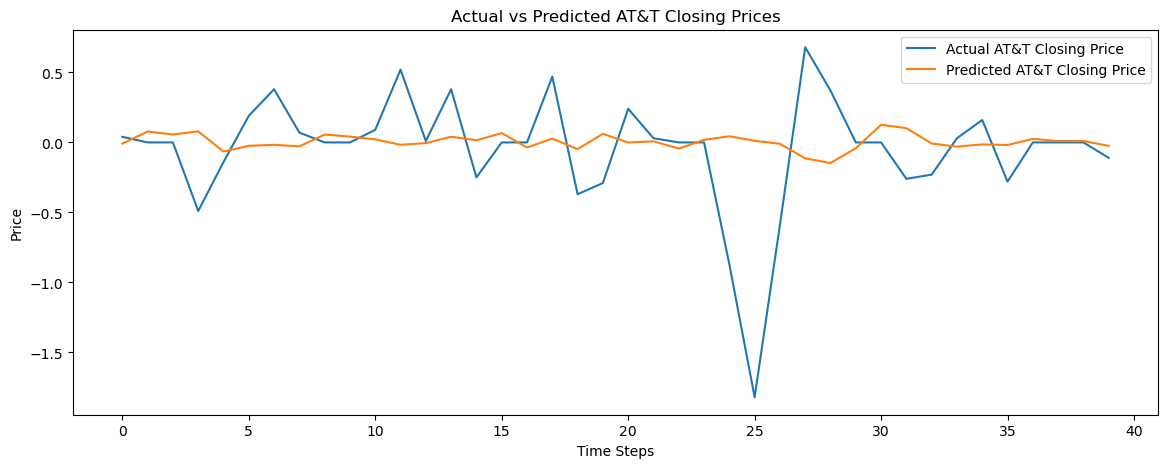

In [31]:
rnn_t.predict()
rnn_t.plot_predictions()

#### Original AT&T Stock Price Prediction

### Verizon Stock Price Prediction

In [72]:
def objective_v(trial):
    # Define the hyperparameter search space
    n_units = trial.suggest_int("n_units", 20, 200)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    window_size = trial.suggest_int("window_size", 5, 30)

    # Re-create the dataset with the current window_size
    X_train, y_train = self._create_dataset(v_train_data, window_size)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    X_val, y_val = self._create_dataset(v_test_data, window_size)
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # Build the model
    model = Sequential()
    model.add(SimpleRNN(units=n_units, activation="tanh", input_shape=(window_size, 1)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1))

    # Compile the model
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mean_squared_error")

    # Define Early Stopping
    early_stop = EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, TFKerasPruningCallback(trial, "val_loss")],
        verbose=0,
    )

    # Evaluate the model on validation data
    val_loss = history.history["val_loss"][-1]

    return val_loss

In [73]:
# Create the Optuna study for Verizon
study_v = optuna.create_study(
    direction="minimize", study_name="SimpleRNN_V Hyperparameter Optimization"
)
study_v.optimize(objective_v, n_trials=50, timeout=600)  # Adjust as needed

# Display the best trial for Verizon
print("Number of finished trials for Verizon: ", len(study_v.trials))
print("Best trial for Verizon:")
trial_v = study_v.best_trial

print("  Value: {}".format(trial_v.value))
print("  Params: ")
for key, value in trial_v.params.items():
    print("    {}: {}".format(key, value))

[I 2025-01-16 22:11:06,360] A new study created in memory with name: SimpleRNN_V Hyperparameter Optimization
[I 2025-01-16 22:11:11,297] Trial 0 finished with value: 0.003017967799678445 and parameters: {'n_units': 68, 'dropout_rate': 0.18210452457255444, 'learning_rate': 1.9289802229857107e-05, 'batch_size': 16, 'window_size': 5}. Best is trial 0 with value: 0.003017967799678445.
[I 2025-01-16 22:11:15,119] Trial 1 finished with value: 0.0032533735502511263 and parameters: {'n_units': 195, 'dropout_rate': 0.10936504888453835, 'learning_rate': 0.0004157840491054802, 'batch_size': 16, 'window_size': 22}. Best is trial 0 with value: 0.003017967799678445.
[I 2025-01-16 22:11:17,063] Trial 2 finished with value: 0.0014373167650774121 and parameters: {'n_units': 72, 'dropout_rate': 0.21422405310193854, 'learning_rate': 0.0011544444308668736, 'batch_size': 128, 'window_size': 30}. Best is trial 2 with value: 0.0014373167650774121.
[I 2025-01-16 22:11:19,169] Trial 3 finished with value: 0.00

Number of finished trials for Verizon:  50
Best trial for Verizon:
  Value: 0.0013337725540623069
  Params: 
    n_units: 198
    dropout_rate: 0.13695913109987162
    learning_rate: 0.00019947646408335145
    batch_size: 16
    window_size: 30


In [74]:
# Retrieve best hyperparameters
best_params = study_v.best_trial.params

# Extract hyperparameters
best_n_units = best_params["n_units"]
best_dropout_rate = best_params["dropout_rate"]
best_learning_rate = best_params["learning_rate"]
best_batch_size = best_params["batch_size"]
best_window_size = best_params["window_size"]

# Prepare the dataset with the best window size
X_train_best, y_train_best = self._create_dataset(t_train_data, best_window_size)
X_train_best = X_train_best.reshape((X_train_best.shape[0], X_train_best.shape[1], 1))

X_val_best, y_val_best = self._create_dataset(t_test_data, best_window_size)
X_val_best = X_val_best.reshape((X_val_best.shape[0], X_val_best.shape[1], 1))

# Build the final model with best hyperparameters
final_model = Sequential()
final_model.add(
    SimpleRNN(units=best_n_units, activation="tanh", input_shape=(best_window_size, 1))
)
final_model.add(Dropout(rate=best_dropout_rate))
final_model.add(Dense(1))

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=best_learning_rate)
final_model.compile(optimizer=optimizer, loss="mean_squared_error")

# Define Early Stopping
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the final model
history = final_model.fit(
    X_train_best,
    y_train_best,
    epochs=100,
    batch_size=best_batch_size,
    validation_data=(X_val_best, y_val_best),
    callbacks=[early_stop],
    verbose=1,
)

# Evaluate the final model
test_loss = final_model.evaluate(X_val_best, y_val_best)
print(f"Final Model Test Mean Squared Error: {test_loss}")

Epoch 1/100
51/51 [==============================] - 1s 8ms/step - loss: 0.0200 - val_loss: 0.0075
Epoch 2/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0078
Epoch 3/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0076 - val_loss: 0.0072
Epoch 4/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0113
Epoch 5/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.0110
Epoch 6/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 7/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0066 - val_loss: 0.0086
Epoch 8/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 0.0093
Epoch 9/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0089
Epoch 10/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0092
Epoch 11/

1/1 [==============================] - 0s 13ms/step


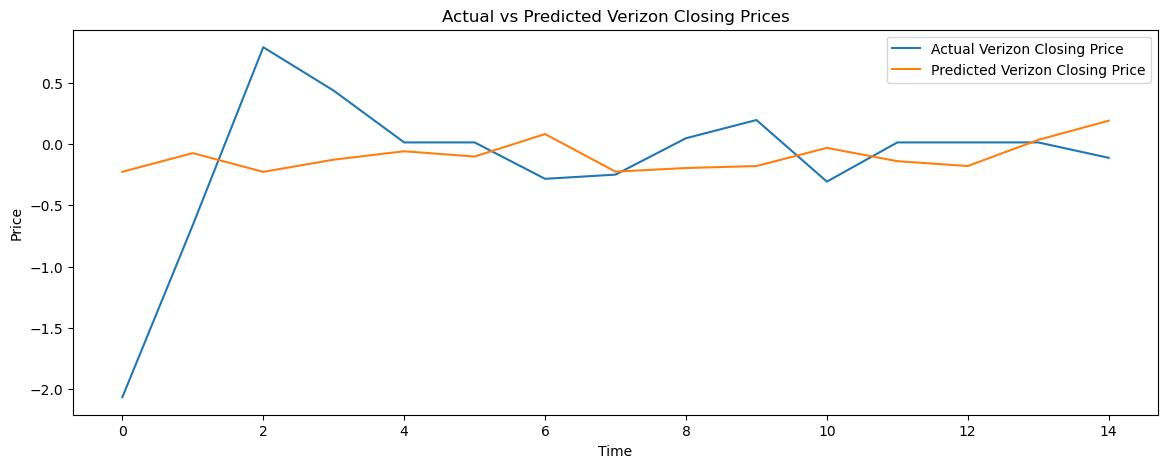

In [76]:
# Make predictions on test data
y_pred_best = final_model.predict(X_val_best)

# Inverse transform the scaled data
v_y_test_actual = scaler_v.inverse_transform(y_val_best.reshape(-1, 1))
v_y_pred_actual = scaler_v.inverse_transform(y_pred_best)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(v_y_test_actual, label="Actual Verizon Closing Price")
plt.plot(v_y_pred_actual, label="Predicted Verizon Closing Price")
plt.title("Actual vs Predicted Verizon Closing Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()